In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_rmse_perc'
metric_filter_2 = 'val_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.3, 0.1, 0.6)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

#### Results

In [ ]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 330/330 [00:25<00:00, 12.75it/s]


In [ ]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6560755,
 'train_acc': 0.5244444608688354,
 'val_acc': 0.4466666281223297,
 'epoch': 30,
 'model_class': 'fnn',
 'path_name': '4_[10_15_20]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_30',
 'train_rmse': 0.9428090415820634,
 'val_rmse': 0.993310961716756,
 'test_rmse': 0.9927515074556953,
 'train_rmse_perc': 0.23002249,
 'val_rmse_perc': 0.23827527,
 'test_rmse_perc': 0.23585929,
 'train_mcc': 0.37624911385300813,
 'val_mcc': 0.2925307989793101,
 'test_mcc': 0.3580610431707958,
 'test_acc': 0.5055555701255798}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6687044,
 'train_acc': 0.5088889002799988,
 'val_acc': 0.4399999678134918,
 'epoch': 40,
 'model_class': 'fnn',
 'path_name': '4_[15_15_15]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_40',
 'train_rmse': 0.8692269873603532,
 'val_rmse': 0.9237604307034013,
 'test_rmse': 0.8793937305515279,
 'train_rmse_perc': 0.21447283,
 'val_rmse_perc': 0.23064746,
 'test_rmse_perc': 0.22316863,
 'train_mcc': 0.3828510952286503,
 'val_mcc': 0.30977927733582916,
 'test_mcc': 0.3708180511389286,
 'test_acc': 0.49888888001441956}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6373744,
 'train_acc': 0.4888888895511627,
 'val_acc': 0.5066666007041931,
 'epoch': 98,
 'model_class': 'fnn',
 'path_name': '4_[15_15]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0',
 'train_rmse': 0.831330927555995,
 'val_rmse': 0.8326663997864531,
 'test_rmse': 0.8647414514048565,
 'train_rmse_perc': 0.2105684,
 'val_rmse_perc': 0.22060584,
 'test_rmse_perc': 0.21801193,
 'train_mcc': 0.3438310869975124,
 'val_mcc': 0.3774501441223187,
 'test_mcc': 0.33015265236154717,
 'test_acc': 0.47777777910232544}

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 330/330 [00:00<00:00, 27573.77it/s]


In [ ]:
cm = all[sort_idx[0]]['test_cm'][0]

In [ ]:
(cm.labels==0).sum()

tensor(230)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

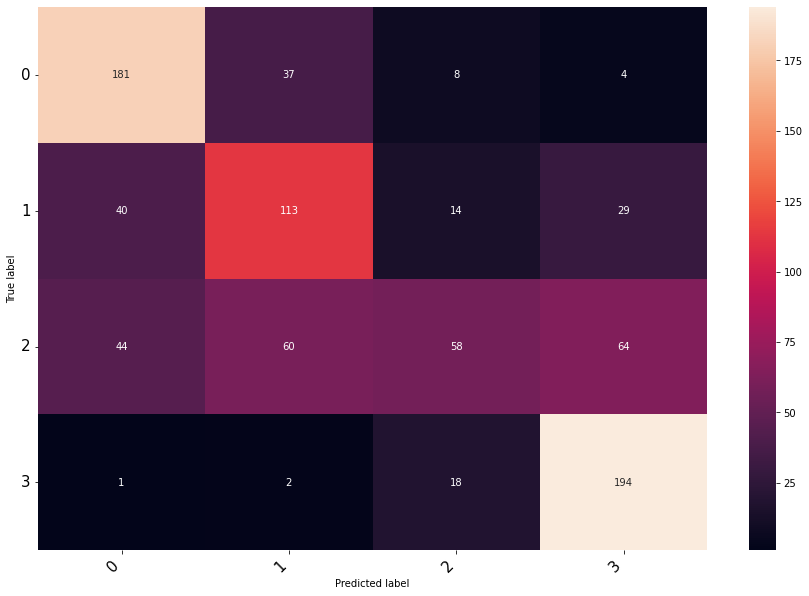

In [ ]:
cm.visualize()

In [ ]:
cm.class_accuracy

tensor([0.7870, 0.5765, 0.2566, 0.9023])

In [ ]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.17763509, 0.2611884, 0.27546555, 0.12878902]

In [ ]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.11359891, 0.18939438, 0.22494318, 0.09887825]

### GCN

In [ ]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [12:51<00:00, 10.72s/it]


#### Results

In [ ]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 792/792 [01:13<00:00, 10.83it/s]


In [ ]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.8592033,
 'train_acc': 0.46888887882232666,
 'val_acc': 0.4399999678134918,
 'epoch': 40,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_True_mse_True_0_40',
 'train_rmse': 0.9614803401237304,
 'val_rmse': 1.0132456102380443,
 'test_rmse': 0.9480975102218594,
 'train_rmse_perc': 0.24854372,
 'val_rmse_perc': 0.27818856,
 'test_rmse_perc': 0.25209934,
 'train_mcc': 0.3570794540963187,
 'val_mcc': 0.32102556843335417,
 'test_mcc': 0.32181411051375597,
 'test_acc': 0.448888897895813}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.75486505,
 'train_acc': 0.4377777874469757,
 'val_acc': 0.41999995708465576,
 'epoch': 50,
 'model_class': 'gcn',
 'path_name': '4_[15_15_15]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_True_mse_True_0_50',
 'train_rmse': 0.8881941729649485,
 'val_rmse': 0.8831760866327847,
 'test_rmse': 0.8838049055708568,
 'train_rmse_perc': 0.21928325,
 'val_rmse_perc': 0.2194965,
 'test_rmse_perc': 0.21648999,
 'train_mcc': 0.34773662768139135,
 'val_mcc': 0.34685166603097983,
 'test_mcc': 0.33871242734349033,
 'test_acc': 0.4322222173213959}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.8837115,
 'train_acc': 0.4266666769981384,
 'val_acc': 0.42666661739349365,
 'epoch': 20,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0.2_20',
 'train_rmse': 0.8944271909999159,
 'val_rmse': 0.8679477710861024,
 'test_rmse': 0.8724168218868267,
 'train_rmse_perc': 0.22383137,
 'val_rmse_perc': 0.22163479,
 'test_rmse_perc': 0.21770823,
 'train_mcc': 0.31936604309327565,
 'val_mcc': 0.3526015834543,
 'test_mcc': 0.3289742668779255,
 'test_acc': 0.4322222173213959}

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 792/792 [00:00<00:00, 27384.37it/s]


### GraphSAGE

In [7]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 144/144 [2:22:01<00:00, 59.18s/it] 


#### Results

In [9]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [05:30<00:00,  3.59it/s]


True

In [10]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.22097655,
 'train_acc': 0.8755555748939514,
 'val_acc': 0.7866665720939636,
 'epoch': 100,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0.2_100',
 'train_rmse': 0.3620926830400072,
 'val_rmse': 0.46188021535170065,
 'test_rmse': 0.5077182070575939,
 'train_rmse_perc': 0.0955169,
 'val_rmse_perc': 0.097058006,
 'test_rmse_perc': 0.11293285,
 'train_mcc': 0.8406196646974875,
 'val_mcc': 0.724312043858121,
 'test_mcc': 0.7191390967884483,
 'test_acc': 0.7811111211776733}

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.22097655,
 'train_acc': 0.8755555748939514,
 'val_acc': 0.7866665720939636,
 'epoch': 100,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0.2_100',
 'train_rmse': 0.3620926830400072,
 'val_rmse': 0.46188021535170065,
 'test_rmse': 0.5077182070575939,
 'train_rmse_perc': 0.0955169,
 'val_rmse_perc': 0.097058006,
 'test_rmse_perc': 0.11293285,
 'train_mcc': 0.8406196646974875,
 'val_mcc': 0.724312043858121,
 'test_mcc': 0.7191390967884483,
 'test_acc': 0.7811111211776733}

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.07511248,
 'train_acc': 0.8866666555404663,
 'val_acc': 0.8333332538604736,
 'epoch': 95,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0',
 'train_rmse': 0.34641016151377546,
 'val_rmse': 0.43204937989385733,
 'test_rmse': 0.5527707983925667,
 'train_rmse_perc': 0.09224023,
 'val_rmse_perc': 0.09688961,
 'test_rmse_perc': 0.118402325,
 'train_mcc': 0.8533825899929406,
 'val_mcc': 0.7880049700266168,
 'test_mcc': 0.6895494125210719,
 'test_acc': 0.757777750492096}

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 29780.26it/s]


#### cm

In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

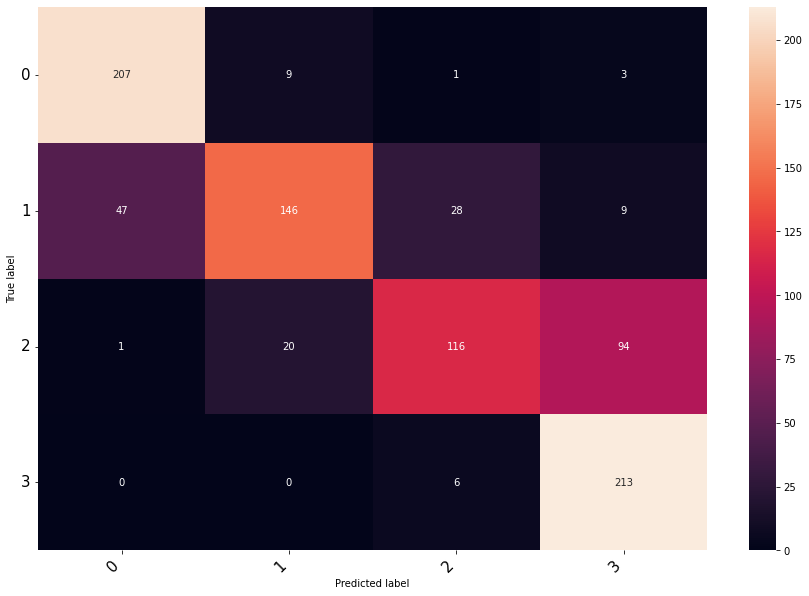

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.9409, 0.6348, 0.5022, 0.9726])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.11559845, 0.13392656, 0.13521889, 0.07788137]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07965881, 0.091815814, 0.104681164, 0.061358716]

#### GraphSAGE Base_n

In [20]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

100%|██████████| 144/144 [2:18:47<00:00, 57.83s/it] 


##### Results

In [22]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [05:40<00:00,  3.49it/s]


True

In [23]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.04951141,
 'train_acc': 0.7644444704055786,
 'val_acc': 0.7266665697097778,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_60',
 'train_rmse': 0.48534065928536785,
 'val_rmse': 0.5228129047119374,
 'test_rmse': 0.5617433182117573,
 'train_rmse_perc': 0.10535672,
 'val_rmse_perc': 0.113051005,
 'test_rmse_perc': 0.11916154,
 'train_mcc': 0.7073445206783293,
 'val_mcc': 0.6460370623263033,
 'test_mcc': 0.6135246676281126,
 'test_acc': 0.6977777481079102}

In [24]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.04951141,
 'train_acc': 0.7644444704055786,
 'val_acc': 0.7266665697097778,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_60',
 'train_rmse': 0.48534065928536785,
 'val_rmse': 0.5228129047119374,
 'test_rmse': 0.5617433182117573,
 'train_rmse_perc': 0.10535672,
 'val_rmse_perc': 0.113051005,
 'test_rmse_perc': 0.11916154,
 'train_mcc': 0.7073445206783293,
 'val_mcc': 0.6460370623263033,
 'test_mcc': 0.6135246676281126,
 'test_acc': 0.6977777481079102}

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.04072621,
 'train_acc': 0.7911111116409302,
 'val_acc': 0.76666659116745,
 'epoch': 70,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_70',
 'train_rmse': 0.4570436400267363,
 'val_rmse': 0.48304589153964794,
 'test_rmse': 0.5859465277082315,
 'train_rmse_perc': 0.11017757,
 'val_rmse_perc': 0.11461048,
 'test_rmse_perc': 0.12857682,
 'train_mcc': 0.7346052275067897,
 'val_mcc': 0.6963967493353268,
 'test_mcc': 0.5799543009450795,
 'test_acc': 0.6766666769981384}

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 31347.84it/s]


##### cm

In [27]:
cm = all[sort_idx[0]]['test_cm'][0]

In [28]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

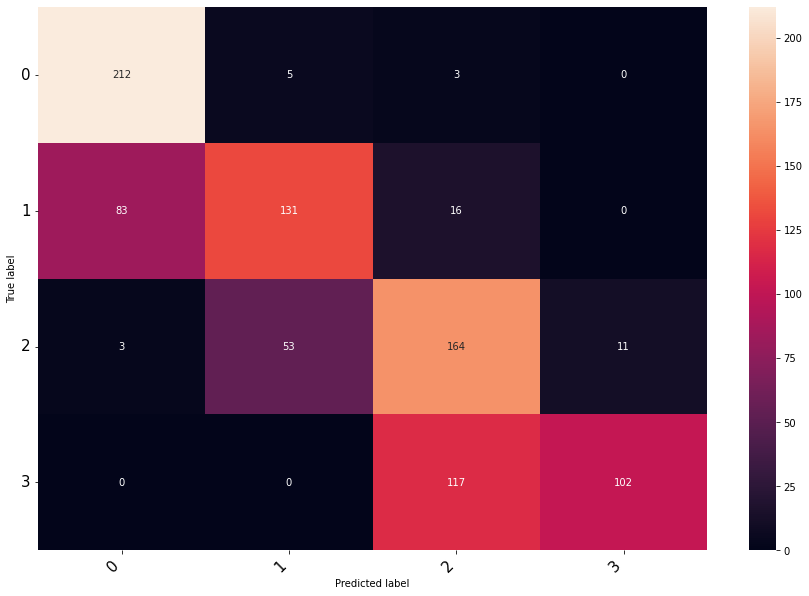

In [29]:
cm.visualize()

In [30]:
cm.class_accuracy

tensor([0.9636, 0.5696, 0.7100, 0.4658])

In [31]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.10734633, 0.12735982, 0.113343574, 0.16055499]

In [32]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.086139165, 0.104650214, 0.08094881, 0.14067718]

### GAT

In [33]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [34]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 288/288 [24:14<00:00,  5.05s/it]


#### Results

In [35]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 3168/3168 [02:35<00:00, 20.40it/s]


In [36]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.70084965,
 'train_acc': 0.5888888835906982,
 'val_acc': 0.5466666221618652,
 'epoch': 80,
 'model_class': 'gat',
 'path_name': '4_[15]_1_[2_2]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2_80',
 'train_rmse': 0.7586537784494028,
 'val_rmse': 0.9237604307034013,
 'test_rmse': 0.7852812659593165,
 'train_rmse_perc': 0.17334342,
 'val_rmse_perc': 0.22473057,
 'test_rmse_perc': 0.18326373,
 'train_mcc': 0.4519725404988363,
 'val_mcc': 0.3967701187445068,
 'test_mcc': 0.45337572044835295,
 'test_acc': 0.58999997

In [37]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.70084965,
 'train_acc': 0.5888888835906982,
 'val_acc': 0.5466666221618652,
 'epoch': 80,
 'model_class': 'gat',
 'path_name': '4_[15]_1_[2_2]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2_80',
 'train_rmse': 0.7586537784494028,
 'val_rmse': 0.9237604307034013,
 'test_rmse': 0.7852812659593165,
 'train_rmse_perc': 0.17334342,
 'val_rmse_perc': 0.22473057,
 'test_rmse_perc': 0.18326373,
 'train_mcc': 0.4519725404988363,
 'val_mcc': 0.3967701187445068,
 'test_mcc': 0.45337572044835295,
 'test_acc': 0.58999997

In [38]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.73154896,
 'train_acc': 0.6177777647972107,
 'val_acc': 0.6133332848548889,
 'epoch': 50,
 'model_class': 'gat',
 'path_name': '4_[25_25]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2_50',
 'train_rmse': 0.7586537784494028,
 'val_rmse': 0.9556847457887634,
 'test_rmse': 0.8743251365736001,
 'train_rmse_perc': 0.17882808,
 'val_rmse_perc': 0.23271239,
 'test_rmse_perc': 0.19929926,
 'train_mcc': 0.49105597221480257,
 'val_mcc': 0.48559483454106933,
 'test_mcc': 0.4277235840906612,
 'test_acc': 0.

In [39]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3168/3168 [00:00<00:00, 28877.01it/s]
